In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df_raw = pd.read_csv('train.csv')
df_raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [22]:
#Creating a copy of the original raw dataset
df = df_raw

#Converting string datetime data to pandas datetime data
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        
for i in range(len(df)):
    if df['tpep_dropoff_datetime'][i] < df['tpep_pickup_datetime'][i]:
        df.loc[i,'tpep_dropoff_datetime'], df.loc[i,'tpep_pickup_datetime'] = df['tpep_pickup_datetime'][i], df['tpep_dropoff_datetime'][i]
        
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']        
        
#Extracting year, month, day, hour and minute from the datetime data
df['pickup_year'] = df['tpep_pickup_datetime'].dt.year
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute

df['dropoff_year'] = df['tpep_dropoff_datetime'].dt.year
df['dropoff_month'] = df['tpep_dropoff_datetime'].dt.month
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.day
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour
df['dropoff_minute'] = df['tpep_dropoff_datetime'].dt.minute

In [23]:
#The dataset contains missing values as well as two categorical variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   VendorID               175000 non-null  int64          
 1   tpep_pickup_datetime   175000 non-null  datetime64[ns] 
 2   tpep_dropoff_datetime  175000 non-null  datetime64[ns] 
 3   passenger_count        168923 non-null  float64        
 4   trip_distance          175000 non-null  float64        
 5   RatecodeID             168923 non-null  float64        
 6   store_and_fwd_flag     168923 non-null  object         
 7   PULocationID           175000 non-null  int64          
 8   DOLocationID           175000 non-null  int64          
 9   payment_type           175000 non-null  object         
 10  extra                  175000 non-null  float64        
 11  tip_amount             175000 non-null  float64        
 12  tolls_amount           175000 

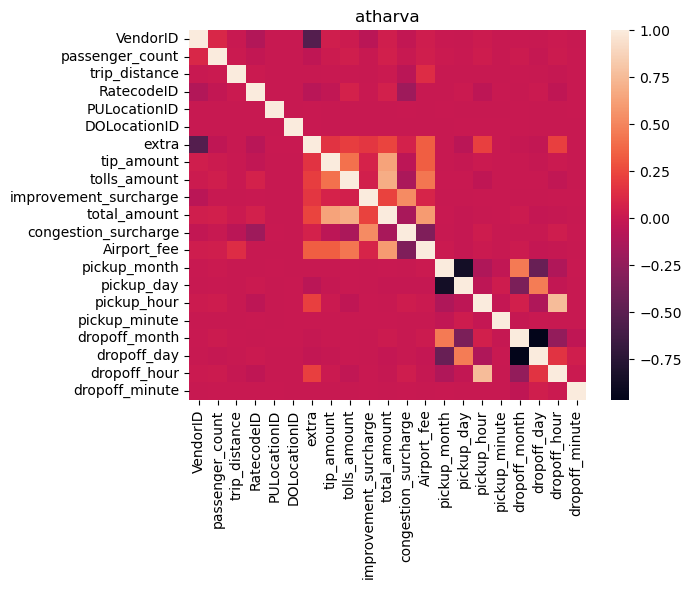

In [24]:
#As the year column contains only one entry, drop the year columns. 
#Drop the datetime columns.
df = df.drop(['pickup_year','dropoff_year'],axis=1)
df = df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1)

image = sns.heatmap(df.corr()).set(title = 'atharva')
plt.savefig('scatter.jpg',
           bbox_inches = 'tight')

In [72]:
#Defining categorical and numerical variables for pipeline formation

cat_variables = ['store_and_fwd_flag',
                 'payment_type']

num_discrete_variables = ['VendorID',
                          'passenger_count',
                          'RatecodeID',
                          'PULocationID',
                          'DOLocationID',
                          'pickup_month',
                          'pickup_day',
                          'pickup_hour',
                          'pickup_minute',
                          'dropoff_month',
                          'dropoff_day',
                          'dropoff_hour',
                          'dropoff_minute']

num_continuous_variables = ['trip_distance',
                            'extra',
                            'tip_amount',
                            'tolls_amount',
                            'improvement_surcharge']

In [177]:
#Importing required preprocessing libraries
from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

#Define feature and target variables
X = df.drop(['total_amount'],
           axis=1)
y = df['total_amount']

#Train-test split
X_train, X_test, y_train, y_test = tts(X,y,
                                       train_size=0.8,
                                       shuffle=True,
                                       random_state=42)

In [180]:
#Define Imputers for filling missing values
si_num_disc = SimpleImputer(strategy='most_frequent')
si_num_cont = SimpleImputer(strategy='mean')
si_cat = SimpleImputer(strategy='most_frequent')

#Define encoders (for categorical variables) and scalers(for numerical variables)
ohe = OneHotEncoder()
ss = StandardScaler()
mas = MaxAbsScaler()
mms = MinMaxScaler()

#Create data preprocessing pipelines

#Pipeline for numerical discrete variables
num_disc_pipeline = Pipeline([
    ('imputer',si_num_disc),
    ('scaler',mms)
])

#Pipeline for numerical continuous variables
num_cont_pipeline = Pipeline([
    ('imputer',si_num_cont),
    ('scaler',ss)
])

#Pipeline for categorical variables
cat_pipeline = Pipeline([
    ('imputer',si_cat),
    ('encoder',ohe),
])

#Final pipeline
final_pipeline = ColumnTransformer([
    ('num_disc_pipeline', num_disc_pipeline, num_discrete_variables),
    ('num_cont_pipeline', num_cont_pipeline, num_continuous_variables),
    ('cat_pipeline', cat_pipeline, cat_variables)
])

#Transform features and labels
X_train_transformed = final_pipeline.fit_transform(X_train)
y_train_transformed = ss.fit_transform(y_train.values.reshape((-1,1)))

In [181]:
#Fitting a simple Linear Regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_transformed,y_train_transformed)

#Testing the fitted model on the test set
X_test_transformed = final_pipeline.fit_transform(X_test)
y_test_transformed = ss.fit_transform(y_test.values.reshape((-1,1)))

y_pred_lr = lr.predict(X_test_transformed)

r2_score(y_test_transformed,y_pred_lr)

0.6734121299377623